# Mechanisms of Action Prediction

#### MultiLabel Classification problem

[Kaggle Link](https://www.kaggle.com/c/lish-moa/data)

In cuurent approaches for Drug discovery, Scientists seek to identify a protein target associated with a disease and develop a molecule that can modulate that protein target. As a shorthand to describe the biological activity of a given molecule, scientists assign a label referred to as mechanism-of-action or MoA for short.

Effects of a drug on the protien target

**Metric** is average logloss for all classes

[Helpful Kaggle Discussion](https://www.kaggle.com/c/lish-moa/discussion/184005)



Tensorflow setup

In [29]:
import pandas as pd
import numpy as np
import os
from myXgboostSuportFns import *

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # new flag present in tf 2.0+

np.random.seed(SEED)

2.3.1


In [1]:
!ls

DataExp.ipynb	       predWork.ipynb	 xgBoostDev.ipynb
dataNmodels	       tfBaseline.ipynb  xgBoostParamTune.ipynb
myXgboostSuportFns.py  Untitled.ipynb	 yPca.npy


In [2]:
xAll = pd.read_csv('../Data/train_features.csv')
yAll = pd.read_csv('../Data/train_targets_scored.csv')

xAll = PreProcessX(xAll)
trainIds= xAll['sig_id'].sample(frac=0.7,random_state=SEED)

In [3]:
xTrain = xAll[xAll['sig_id'].isin(trainIds)]
yTrain = yAll[yAll['sig_id'].isin(trainIds)]
xValid = xAll[~xAll['sig_id'].isin(trainIds)]
yValid = yAll[~yAll['sig_id'].isin(trainIds)]
print(f'xTrain {xTrain.shape} yTrain {yTrain.shape} xValid {xValid.shape} yValid {yValid.shape}')

xTrain (16670, 876) yTrain (16670, 207) xValid (7144, 876) yValid (7144, 207)


In [4]:
idList=['sig_id']
xTrain=xTrain.drop(idList,axis=1)
xValid=xValid.drop(idList,axis=1)
yTrain=yTrain.drop(idList,axis=1)
yValid=yValid.drop(idList,axis=1)

In [5]:
xTrain['cp_time'] = (xTrain['cp_time'] - xTrain['cp_time'].mean())/xTrain['cp_time'].std()

In [6]:
xTrain.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,1,-1.229442,1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
2,1,0.007569,1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,1,0.007569,1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,1,1.244580,0,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
5,1,-1.229442,1,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,0.0543,...,1.8390,1.1570,-1.0120,1.9010,1.4270,0.4519,1.2120,0.3765,0.7848,1.3990


In [44]:
def getModel(xTrain,yTrain, l1Pen = 0.0001,l2Pen= 0.00005,dropRate=0.6):
    '''
    1 instance of model
    this will build and fit a model
    Used for iterative process
    '''
    
    model =Sequential([
        Dense(128,activation='relu',input_shape= (xTrain.shape[1],),   
        kernel_regularizer=tf.keras.regularizers.l1(l1Pen)),
        BatchNormalization(),  # for covariate_shift
        Dense(128,activation="relu"),
        BatchNormalization(),  
        Dropout(0.6), 
        Dense(64,activation="relu",kernel_regularizer=tf.keras.regularizers.l2(l2Pen)),
        BatchNormalization(),  
        Dropout(0.3),      
        Dense(64,activation="relu",kernel_regularizer=tf.keras.regularizers.l2(l2Pen)),
        BatchNormalization(), 
        Dropout(0.3),
        Dense(32,activation="relu",kernel_regularizer=tf.keras.regularizers.l2(l2Pen)),
        BatchNormalization(), 
        Dropout(0.3),
        Dense(yTrain.shape[1],activation='sigmoid')
    ])
    
    model.compile(optimizer ='Nadam'
             ,loss= 'binary_crossentropy'
             )
    return model

In [45]:
model = getModel(xTrain,yTrain,l1Pen = 0.00005,l2Pen= 0.00001,dropRate=0.2)

In [46]:
early_stopping = EarlyStopping(monitor='val_loss',patience = 50,min_delta=1e-7)
history = model.fit(xTrain,yTrain,epochs=1000,batch_size=32,verbose=0,validation_split=0.2,
                    callbacks=[early_stopping
                               ,tf.keras.callbacks.ReduceLROnPlateau(
                        monitor="val_loss",factor=0.3, verbose=1,cooldown=2,patience = 30,min_delta=1e-4)
                              ])


Epoch 00159: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 00218: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 00274: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.

Epoch 00307: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.

Epoch 00338: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.

Epoch 00369: ReduceLROnPlateau reducing learning rate to 7.289999985005124e-07.

Epoch 00400: ReduceLROnPlateau reducing learning rate to 2.1870000637136398e-07.

Epoch 00431: ReduceLROnPlateau reducing learning rate to 6.561000276406048e-08.

Epoch 00462: ReduceLROnPlateau reducing learning rate to 1.9683000829218145e-08.


,loss,val_loss,lr
0,0.497043,0.169990,1.000000e-03
1,0.121785,0.078862,1.000000e-03
2,0.062339,0.047551,1.000000e-03
3,0.045290,0.040888,1.000000e-03
4,0.038761,0.034707,1.000000e-03
...,...,...,...
463,0.016840,0.016875,1.968300e-08
464,0.016820,0.016869,1.968300e-08
465,0.016841,0.016873,1.968300e-08
466,0.016889,0.016872,1.968300e-08


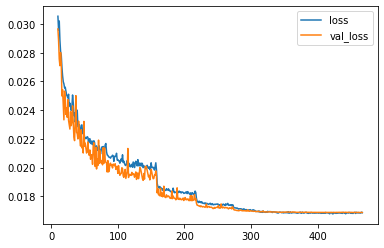

In [47]:
df= pd.DataFrame(history.history)
df.iloc[10:,:].plot(y=['loss','val_loss'])

df

In [48]:
model.evaluate(xValid,yValid)

224/224 [==============================] - 0s 565us/step - loss: 0.0167


0.01671508513391018

In [49]:

def getLogLoss(y,yhat):
    '''
    logloss
    '''
    assert len(y)==len(yhat)
    eps= 1e-12
    
    yhat= np.clip(yhat,eps,1-eps)
    return -1*np.mean(y*np.log(yhat) + (1-y)*np.log(1-yhat))

In [50]:
preds =pd.DataFrame(model.predict(xValid),columns=yValid.columns)
resultsDf = pd.DataFrame(yValid.columns,columns=['varname'])
resultsDf['logloss'] = resultsDf['varname'].map(lambda var: getLogLoss(yValid[var].values,preds[var].values) )

In [51]:
resultsDf['valCount'] = resultsDf['varname'].map(lambda var: yValid[var].sum()) 
resultsDf['Prop'] = resultsDf['varname'].map(lambda var: yValid[var].sum()/(yValid.shape[0]))
resultsDf.sort_values(by=['logloss'],ascending=False, inplace=True)\

resultsDf.head(20)

,varname,logloss,valCount,Prop
71,cyclooxygenase_inhibitor,0.090007,138,0.019317
77,dna_inhibitor,0.086407,130,0.018197
177,serotonin_receptor_antagonist,0.083214,124,0.017357
79,dopamine_receptor_antagonist,0.082248,122,0.017077
99,glutamate_receptor_antagonist,0.078240,116,0.016237
10,adrenergic_receptor_antagonist,0.070917,102,0.014278
4,acetylcholine_receptor_antagonist,0.066518,96,0.013438
54,calcium_channel_blocker,0.062546,86,0.012038
151,phosphodiesterase_inhibitor,0.057938,79,0.011058
9,adrenergic_receptor_agonist,0.054273,74,0.010358


In [52]:
np.mean(resultsDf.logloss)

0.016296068082629258